In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleModels as nrn
from scipy.interpolate import interp1d
from time import time
from scipy.ndimage import gaussian_filter1d

In [2]:
def create_random_ntk(n_exc, n_inh, probs):
    n_cells = n_exc + n_inh
    cell_types = []
    cnt_map = np.ones([n_cells, n_cells], dtype=np.int) * (-1)
    gtype = [[0, 1], [2, 3]]
    for i in range(n_cells):
        if i < n_exc:
            cell_types.append(0)
        else:
            cell_types.append(1)
            
    for i in range(n_cells):
        cpre = cell_types[i]
        for j in range(n_cells):
            if i != j:
                cpost = cell_types[j]
                p = np.random.uniform(0, 1)
                if p <= probs[cpre][cpost]:
                    cnt_map[i][j] = gtype[cpre][cpost]
    return cell_types, cnt_map

def single_input(tau_r=0.1, tau_d=5, onset=50):
    tau1, tau2 = nrn.convert_tau_rdto12(tau_r, tau_d)
    B = nrn.get_syn_norm(tau_r, tau_d)
    return nrn.f_syn(nrn._times[1:], onset, 0, tau1, tau2, B)

def basic_labeling(title=None):
    plt.xlabel('time (ms)', fontsize=12)
    plt.ylabel('voltage (mV)', fontsize=12)
    plt.title(title, fontsize=15)
    plt.xlim([0, nrn._tmax])
    
def get_spk_hist(vcells, t, w=100, m=10):
    n = len(t)
    ids = np.arange(0, n-w+1, m)
    nid = len(ids)
    hist = np.zeros(nid)    
    boolx = vcells == 30
    for n in range(nid):
        hist[n] = np.sum(boolx[ids[n]:ids[n]+w])
    x = np.array(t)
    x = x[ids]
    return hist, x

def getFFT(x, idt):
    fx = np.fft.fft(x[idt]) / sum(idt)
    f = np.fft.fftfreq(sum(idt), nrn._dt/(1e3))
    fx = abs(fx[:int(sum(idt)//2)])
    f = f[:int(sum(idt)//2)]
    return f, fx

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def find_peak(x, f, idf=None):
    if idf is None:
        idf = np.ones(len(x), dtype=bool)
    ind = np.where(x == max(x[idf]))[0][0]
    return f[ind]

def get_gext(f, p_pos, w_rand=100, t0=None, t1=None, tau_r=0.1, tau_d=5, d=0):
    if t0 is None:
        t0 = 0
    if t1 is None:
        t1 = nrn._tmax
    # f Hz
    i0 = int(t0 / nrn._dt)
    i1 = int(t1 / nrn._dt)
    id_onsets = []
    while i0 < i1:
        id_onsets.append(i0 + np.random.randint(-w_rand//2, w_rand//2))
        i0 += 1e3/f/nrn._dt       
    # random values
    p_bd = p_pos * nrn._dt
    rands = np.random.uniform(low=0, high=1, size=nrn._nitr)
    for i in np.where(rands < p_bd)[0]:
        if (nrn._times[i]<t0) | (nrn._times[i]>t1):
            id_onsets.append(i)
    id_onsets = np.array(id_onsets, dtype=np.int)
    id_onsets = np.sort(id_onsets)
    # get ghat
    n = 0
    onset = 100
    tau1, tau2 = nrn.convert_tau_rdto12(tau_r, tau_d)
    B = nrn.get_syn_norm(tau_r, tau_d)
    g = np.zeros(nrn._nitr)
    for i, t in enumerate(nrn._times[1:]):
        if n < len(id_onsets):
            if i == id_onsets[n]:
                onset = nrn._times[i]
                n += 1
        if ((t - onset) >= d) and ((t - onset) < tau_d*5):
            g[i] = B * (np.exp(-(t-onset-d)/tau1) - np.exp(-(t-onset-d)/tau2))
    return g

def select_targets(n_ext, n_target, n_pick, n_overlap):
    
    targets = []
    for i in range(n_target):
        for j in range(n_overlap):
            targets.append(i)
            targets.append(i)
        
    target_ids = []
    for i in range(n_ext):
        # pick n_pick cells
        target_ids.append([np.random.choice(targets)])
        targets.remove(target_ids[-1][0])
        for j in range(1, n_pick):
            while True:
                n = np.random.choice(targets)
                if n != target_ids[-1][j-1]:
                    target_ids[-1].append(n)
                    targets.remove(n)
                    break
                    
    return target_ids

def show_summaray(ntk):
    cs = ['r', 'b']

    plt.figure(dpi=150, figsize=(9, 6))
    
    plt.subplot(3,1,1)
    for i in range(n_cells):
        plt.plot(nrn._times, ntk.vcells[:, i], lw=0.1, c=cs[cell_types[i]], alpha=0.5)
    basic_labeling('raw trace')
    plt.ylim([-80, 40])
    plt.xlabel('')

    plt.subplot(3,1,2)
    for i in range(1, n_cells+1):
        plt.vlines(ntk.spks[i-1], i-0.3, i+0.3, color=cs[cell_types[i-1]], lw=0.5)
    basic_labeling('raster plot')
    plt.ylabel('# spike')
    # plt.yticks(np.arange(0, 11, 2))
    plt.ylim([-0.5, n_cells+1])
    plt.xlabel('')

    hist, x = get_spk_hist(ntk.vcells, nrn._times, w=200, m=5)
    plt.subplot(3,1,3)
    plt.plot(x, hist, 'k', lw=0.5)
    basic_labeling('spike histogram')
    plt.ylabel('num of the spike')

    plt.tight_layout()
    plt.show()
    
def set_ext_params(n_excs, n_pfcs_e, n_pfcs_i, n_pick, n_overlap, cell_types, gbar_m, gbar_s):
    
    ######## gbar_exc # gbar_pfc_exc # gbar_pfc_inh ######
    # to PN           #              #              ######
    ######################################################
    # to PV           #              #              ######
    ######################################################
    
    target_ids_all = select_targets(n_excs+n_pfcs_e+n_pfcs_i, len(cell_types), n_pick, n_overlap)
    gbar_all = []
    es_all = []
    
    # region X
    for i in range(n_excs):
        gbar_all.append([])
        for j in target_ids_all[i]:
            if cell_types[j] == 0:
                gbar_all[-1].append(abs(np.random.normal(loc=gbar_m[0][0], scale=gbar_s[0][0])))
            else:
                gbar_all[-1].append(abs(np.random.normal(loc=gbar_m[1][0], scale=gbar_s[1][0])))
        es_all.append(0)
    
    # PFC signal to exc
    for i in range(n_pfcs_e):
        gbar_all.append([])
        for j in target_ids_all[i]:
            if cell_types[j] == 0:
                gbar_all[-1].append(abs(np.random.normal(loc=gbar_m[0][1], scale=gbar_s[0][1])))
            else:
                gbar_all[-1].append(abs(np.random.normal(loc=gbar_m[1][1], scale=gbar_s[1][1])))
        es_all.append(0)
        
    # PFC signal to inh
    for i in range(n_pfcs_i):
        gbar_all.append([])
        for j in target_ids_all[i]:
            if cell_types[j] == 0:
                gbar_all[-1].append(abs(np.random.normal(loc=gbar_m[0][2], scale=gbar_s[0][2])))
            else:
                gbar_all[-1].append(abs(np.random.normal(loc=gbar_m[1][2], scale=gbar_s[1][2])))
        es_all.append(-80)
    
    return target_ids_all, gbar_all, es_all

def get_fft_summary(v, t_range):
    
    idt = (nrn._times>t_range[0]) & (nrn._times<t_range[1])
    f, fx = getFFT(v, idt)
    idf = f > 1
    f = f[idf]
    fx = fx[idf]
    
    plt.figure(dpi=150)
    plt.plot(f, fx, 'k', lw=0.5)
    plt.xticks(np.arange(0, 105, 10))
    plt.xlim([10, 100])
    plt.xlabel('frequency (Hz)', fontsize=12)
    plt.ylabel('amplitude (mV)', fontsize=12)
    plt.show()
    
    return f, fx

In [55]:
params_pn = {'tau':20, 'r':100, 'vth':-40, 'v0':-65, 'vahp':-80, 'vmax':30, 'ev':-65, 'tahp':10}
params_pv = {'tau':5, 'r':100, 'vth':-50, 'v0':-65, 'vahp':-80, 'vmax':30, 'ev':-65, 'tahp':0}

In [56]:
syn_pn2pn = {'gbar_syn':0.004, 'tau_r':0.1, 'tau_d':8, 'es':0}
syn_pn2pv = {'gbar_syn':0.002, 'tau_r':0.1, 'tau_d':2, 'es':0}
syn_pv2pn = {'gbar_syn':0.004, 'tau_r':0.1, 'tau_d':4, 'es':-80}
syn_pv2pv = {'gbar_syn':0.001, 'tau_r':0.1, 'tau_d':4, 'es':-80}

# syn_pn2pn = {'gbar_syn':0.005, 'tau_r':0.1, 'tau_d':5, 'es':0}
# syn_pn2pv = {'gbar_syn':0.0025, 'tau_r':0.1, 'tau_d':5, 'es':0}
# syn_pv2pn = {'gbar_syn':0.005, 'tau_r':0.1, 'tau_d':5, 'es':-80}
# syn_pv2pv = {'gbar_syn':0.0025, 'tau_r':0.1, 'tau_d':5, 'es':-80}

In [168]:
t1, t2 = nrn.convert_tau_rdto12(0.1, 5)
print(nrn.get_syn_norm(0.1, 5))

1.1034587734462786


In [167]:
print(a, b)

5 0.09803921568627452


In [57]:
nrn.set_times(tmax=500, dt=0.01)
seed = 102107
nrn.set_seed(seed)

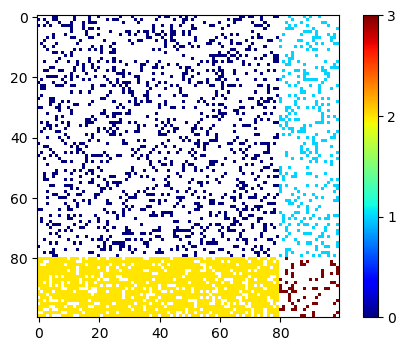

In [58]:
n_exc = 80
n_inh = 20
n_cells = n_exc + n_inh
probs = [[0.2, 0.2], [0.8, 0.2]]
# create cell types
cell_types, cnt_map = create_random_ntk(n_exc, n_inh, probs)
setting = nrn.get_params([params_pn, params_pv],
                         [syn_pn2pn, syn_pn2pv, syn_pv2pn, syn_pv2pv],
                         cell_types, cnt_map, delay_m=1, delay_s=0.1)

plt.figure(dpi=100)
cnt_map_view = cnt_map.copy()
cnt_map_view = cnt_map_view.astype(np.float)
cnt_map_view[cnt_map_view == -1] = np.nan
plt.imshow(cnt_map_view, cmap='jet')
cbar = plt.colorbar()
cbar.set_ticks([0, 1, 2, 3])
plt.show()

# One time stimulation 

In [59]:
# random onset
onsets = np.random.uniform(10, 12, n_exc)
# onsets = np.ones(n_exc) * 10
gstims = np.zeros([nrn._nitr, n_exc])
for i in range(n_exc):
    gstims[:, i] = single_input(onset=onsets[i])

In [60]:
gbar_to_pn = 0.1
gbar_ext = []
target_ids = []
for i in range(n_exc):
    target_ids.append([i])
    gbar_ext.append([gbar_to_pn])
es = np.zeros(n_exc)

In [61]:
ntk_one_time = nrn.CellNetwork(**setting, g_ext=gstims, e_ext=es, gbar_ext=gbar_ext, target_id=target_ids, std=0.15)
ntk_one_time.run()

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:20<00:00, 621.79it/s]


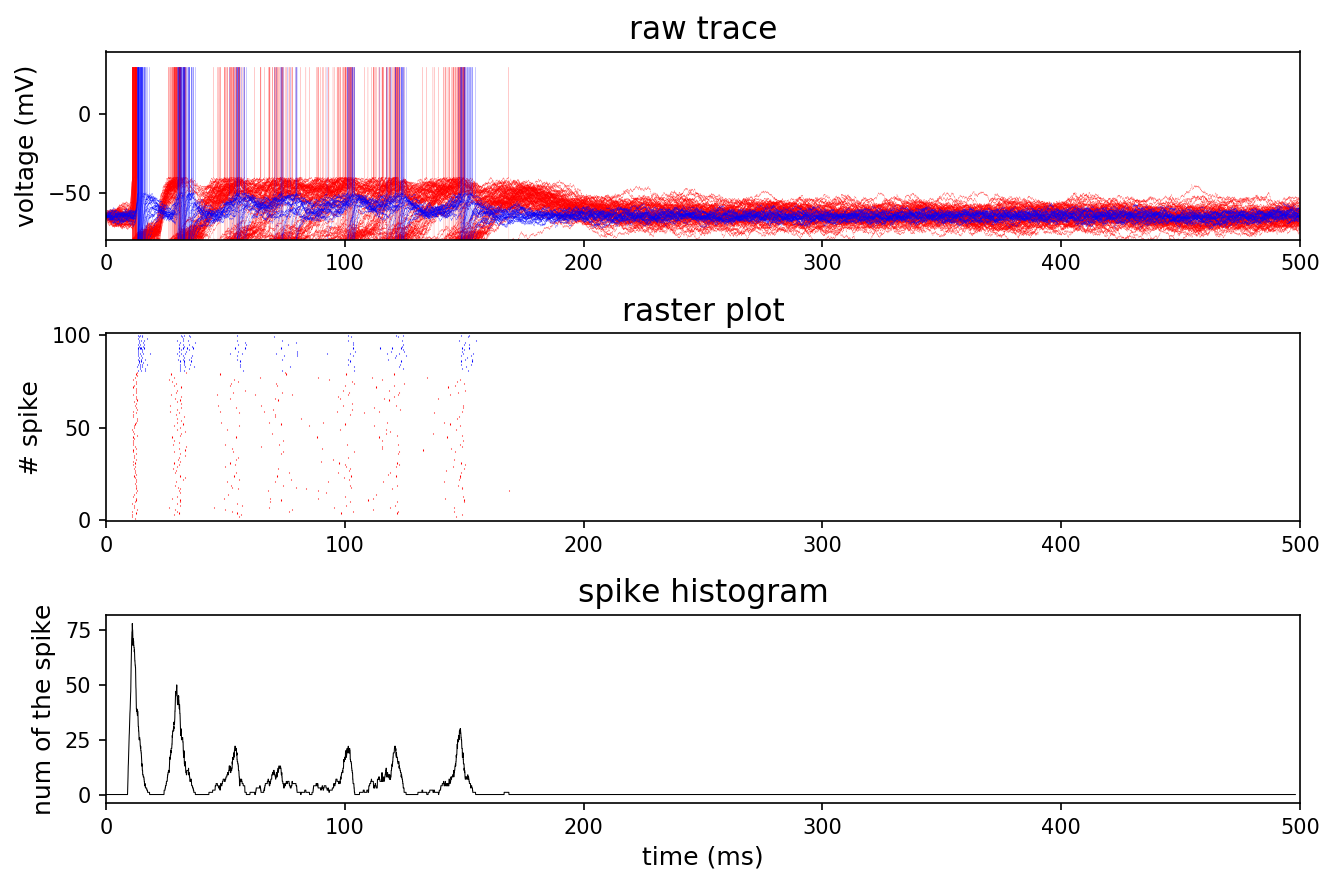

In [62]:
cs = ['r', 'b']

plt.figure(dpi=150, figsize=(9, 6))

plt.subplot(3,1,1)
for i in range(n_cells):
    plt.plot(nrn._times, ntk_one_time.vcells[:, i], lw=0.1, c=cs[cell_types[i]], alpha=0.5)
basic_labeling('raw trace')
plt.ylim([-80, 40])
plt.xlabel('')

plt.subplot(3,1,2)
for i in range(1, n_cells+1):
    plt.vlines(ntk_one_time.spks[i-1], i-0.3, i+0.3, color=cs[cell_types[i-1]], lw=0.5)
basic_labeling('raster plot')
plt.ylabel('# spike')
# plt.yticks(np.arange(0, 11, 2))
plt.ylim([-0.5, n_cells+1])
plt.xlabel('')

hist, x = get_spk_hist(ntk_one_time.vcells, nrn._times, w=200, m=5)
plt.subplot(3,1,3)
plt.plot(x, hist, 'k', lw=0.5)
basic_labeling('spike histogram')
plt.ylabel('num of the spike')

plt.tight_layout()
plt.show()

In [63]:
vsum = np.average(ntk_one_time.vcells, axis=1)
idt = (nrn._times>10) & (nrn._times<100)
f, fx = getFFT(vsum, idt)
idf = f > 1
f = f[idf]
fx = fx[idf]
n = 10
fx_avg = moving_average(fx, n=n)

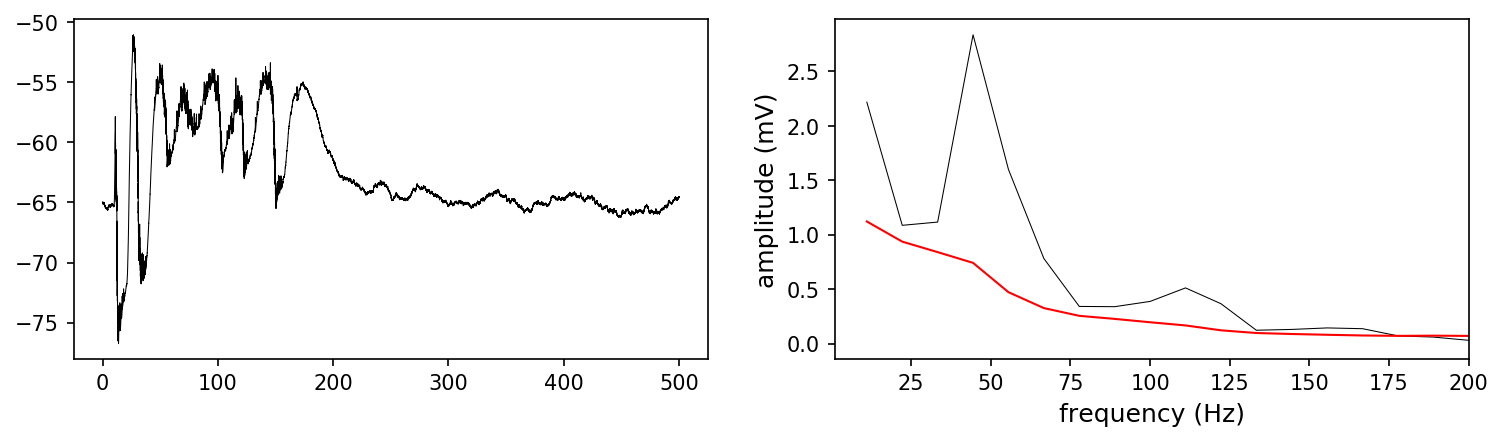

In [64]:
plt.figure(dpi=150, figsize=(12, 3))
plt.subplot(121)
plt.plot(nrn._times, vsum, 'k', lw=0.5)
# plt.plot(nrn._times[idt], vsum[idt], 'k', lw=0.5)
# plt.xticks([0, 15, 30])

plt.subplot(122)
plt.plot(f, fx, 'k', lw=0.5)
plt.plot(f[:-n+1], fx_avg, 'r', lw=1)
plt.xlim([1, 200])
# plt.ylim([0, 0.3])
plt.xlabel('frequency (Hz)', fontsize=12)
plt.ylabel('amplitude (mV)', fontsize=12)

plt.show()

In [65]:
np.save('./data/one_time_stim', ntk_one_time.vcells)
np.save('./data/one_time_stim', ntk_one_time.spks)
del ntk_one_time

# heterogeneous background inputntk_one_time.spks

In [66]:
nrn.set_times(tmax=500, dt=0.01)
seed = 102300
nrn.set_seed(seed)

In [37]:
n_excs = 100
# create background excitatory input; g_excs, es
g_excs = np.zeros([nrn._nitr, n_excs])
for i in range(n_excs):
    g_excs[:, i] = nrn.gPoisson(0.1, 0.1, 5, delay=0, t0=0, t1=500)

In [38]:
target_ids = select_targets(n_excs, n_cells, 2, 2)
es = np.zeros(n_excs)
# gbar
gbar_to_exc = 0.004 # syn_pn2pn['gbar_syn']
std_exc = 0.001

gbar_to_inh = 0.0008
std_inh = 0.0003

gbar_ext = []
for i in range(n_excs):
    gbar_ext.append([])
    for j in target_ids[i]:
        if cell_types[j] == 0:
            gbar_ext[-1].append(np.random.normal(loc=gbar_to_exc, scale=std_exc))
        else:
            gbar_ext[-1].append(np.random.normal(loc=gbar_to_inh, scale=std_inh))

In [39]:
ntk_all_time = nrn.CellNetwork(**setting, g_ext=g_excs, e_ext=es, gbar_ext=gbar_ext, target_id=target_ids, std=0.1)
ntk_all_time.run()

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:25<00:00, 585.61it/s]


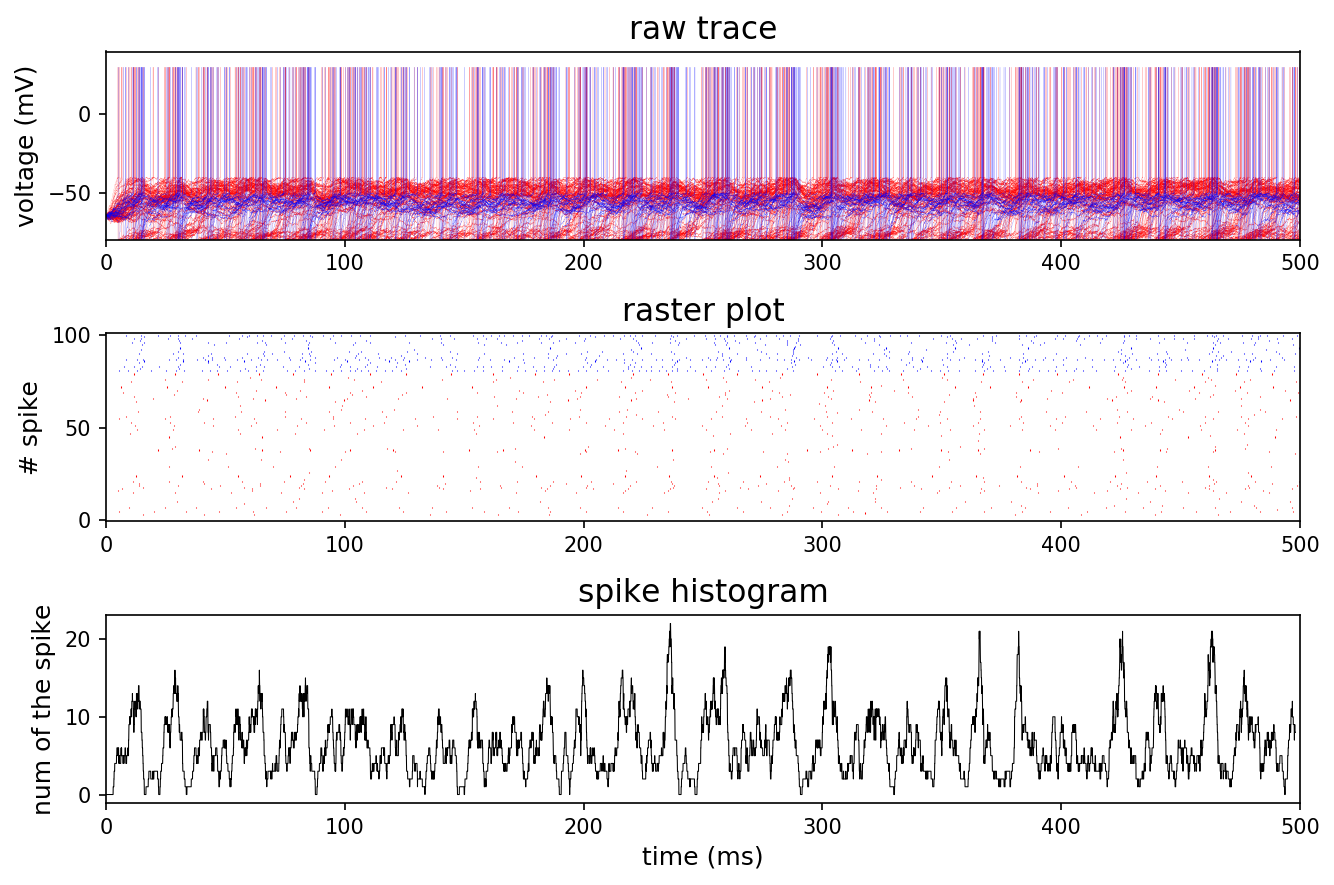

In [40]:
cs = ['r', 'b']

plt.figure(dpi=150, figsize=(9, 6))
plt.subplot(3,1,1)
for i in range(n_cells):
    plt.plot(nrn._times, ntk_all_time.vcells[:, i], lw=0.1, c=cs[cell_types[i]], alpha=0.5)
basic_labeling('raw trace')
plt.ylim([-80, 40])
plt.xlabel('')

plt.subplot(3,1,2)
for i in range(1, n_cells+1):
    plt.vlines(ntk_all_time.spks[i-1], i-0.3, i+0.3, color=cs[cell_types[i-1]], lw=0.5)
basic_labeling('raster plot')
plt.ylabel('# spike')
# plt.yticks(np.arange(0, 11, 2))
plt.ylim([-0.5, n_cells+1])
plt.xlabel('')

hist, x = get_spk_hist(ntk_all_time.vcells, nrn._times, w=200, m=5)
plt.subplot(3,1,3)
plt.plot(x, hist, 'k', lw=0.5)
basic_labeling('spike histogram')
plt.ylabel('num of the spike')

plt.tight_layout()
plt.show()

In [41]:
std_i = np.std(ntk_all_time.vcells, axis=0)
std_all = np.std(np.average(ntk_all_time.vcells, axis=1))
si = std_all**2 * ntk_all_time.nn / sum(std_i**2)
print(si)

0.021887681621916764


In [42]:
vsum = np.average(ntk_all_time.vcells, axis=1)

idt = (nrn._times>100) & (nrn._times<400)
f, fx = getFFT(vsum, idt)
idf = f > 1
f = f[idf]
fx = fx[idf]
n = 5
fx_avg = moving_average(fx, n=n)

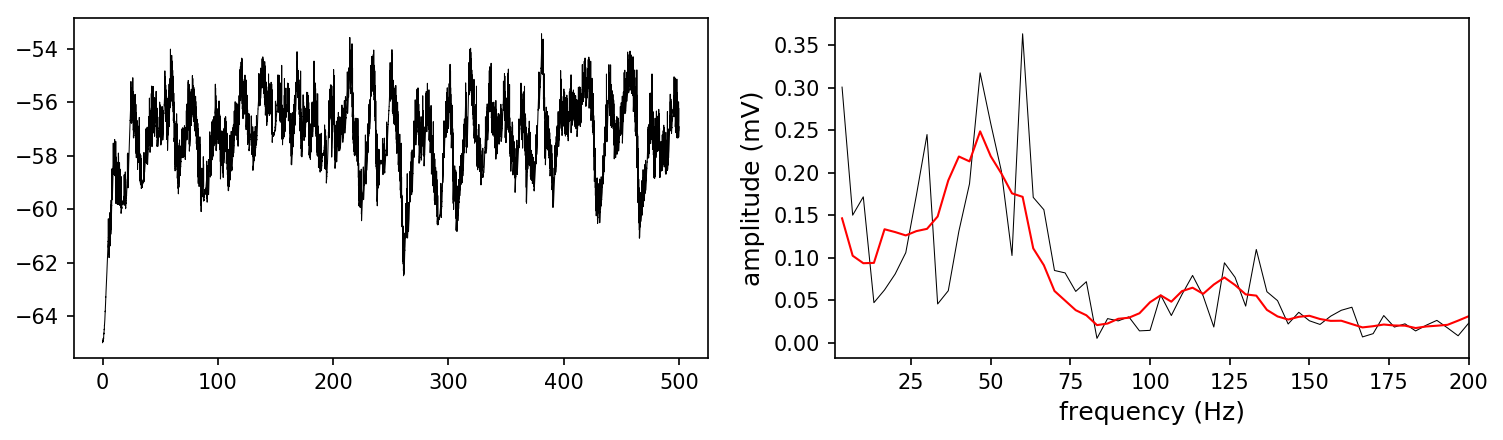

In [43]:
plt.figure(dpi=150, figsize=(12, 3))
plt.subplot(121)
plt.plot(nrn._times, vsum, 'k', lw=0.5)
# plt.xticks([0, 15, 30])
# plt.xlim([100, 130])

plt.subplot(122)
plt.plot(f, fx, 'k', lw=0.5)
plt.plot(f[:-n+1], fx_avg, 'r', lw=1)
plt.xlim([1, 200])
# plt.ylim([0, 0.3])
plt.xlabel('frequency (Hz)', fontsize=12)
plt.ylabel('amplitude (mV)', fontsize=12)

plt.show()

In [44]:
find_peak(fx, f)

60.00200006666888

In [54]:
np.save('./data/heterogen_stim_v', ntk_all_time.vcells)
np.save('./data/heterogen_stim_spk', ntk_all_time.spks)
del ntk_all_time

# E/I balance model

## 30 Hz

In [94]:
nrn.set_times(tmax=250, dt=0.01)
seed = 102107
nrn.set_seed(seed)

In [95]:
n_excs = 100
n_pfcs_exc = 50
n_pfcs_inh = 50
# create background excitatory input; g_excs, es
g_excs_all = np.zeros([nrn._nitr, n_excs+n_pfcs_exc+n_pfcs_inh])
for i in range(n_excs):
    g_excs_all[:, i] = nrn.gPoisson(0.1, 0.1, 5, delay=0, t0=0, t1=300)
for i in range(n_pfcs_exc + n_pfcs_inh):
    g_excs_all[:, n_excs+i] = get_gext(30, 0.01, 1000, t0=50, t1=200, tau_r=0.1, tau_d=5)

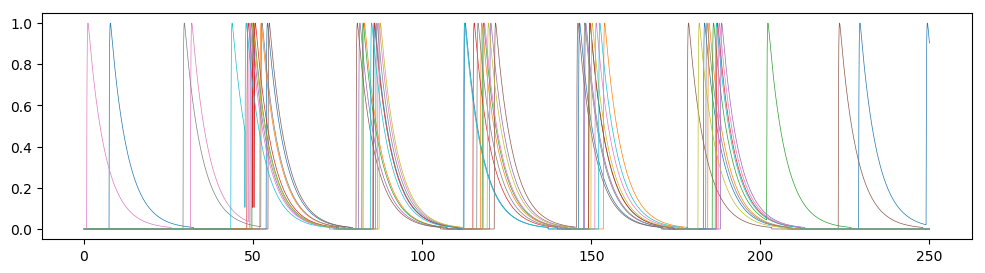

In [96]:
plt.figure(dpi=100, figsize=(12, 3))
plt.plot(nrn._times[1:], g_excs_all[:, -10:], lw=0.5)
plt.show()

In [97]:
gbar_m = [[0.004, 0.004, 0.00], [0.0004, 0.0004, 0]]
gbar_s = [[0.001, 0.001, 0], [0.0001, 0.0001, 0]]
target_ids_all, gbar_all, es_all = set_ext_params(n_excs, n_pfcs_exc, n_pfcs_inh, 2, 4, cell_types, gbar_m, gbar_s)

In [98]:
np.save('./data/all_inputs_g', g_excs_all)
np.save('./data/all_inputs_gbar', gbar_all)
np.save('./data/all_inputs_target', target_ids_all)
np.save('./data/all_inputs_e', es_all)

In [99]:
ntk_w_pfc = nrn.CellNetwork(**setting, g_ext=g_excs_all, e_ext=es_all, gbar_ext=gbar_all, target_id=target_ids_all, std=0.1)
ntk_w_pfc.run()

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:44<00:00, 565.25it/s]


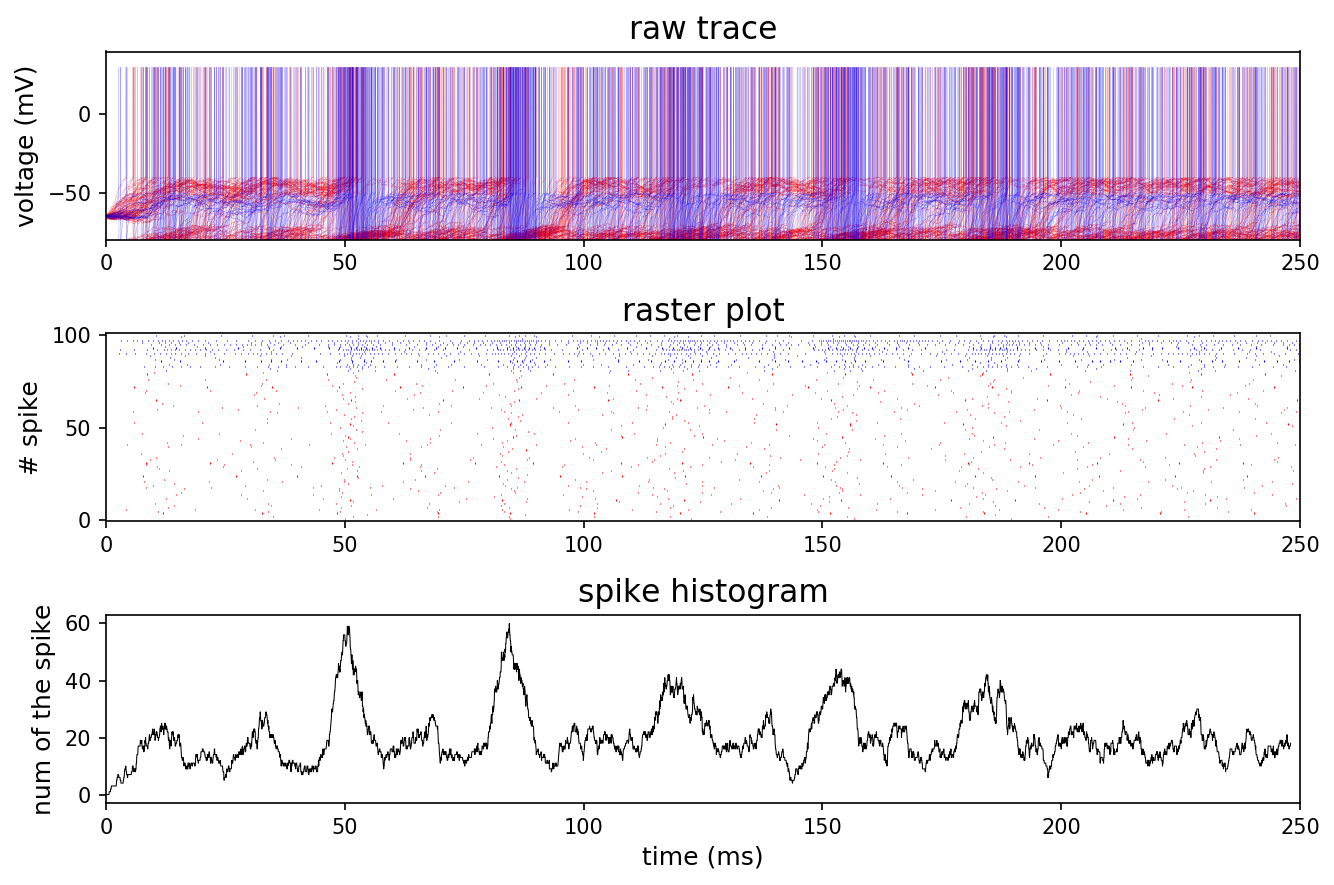

In [100]:
show_summaray(ntk_w_pfc)

In [101]:
np.save('./data/ntk_w_pfc_sample_v', ntk_w_pfc.vcells)
np.save('./data/ntk_w_pfc_sample_spk', ntk_w_pfc.spks)

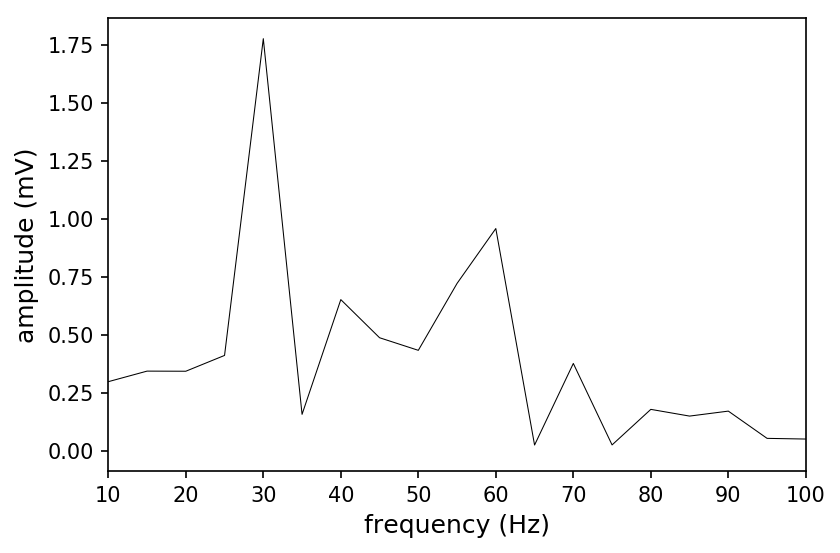

In [102]:
f, fx = get_fft_summary(np.average(ntk_w_pfc.vcells, axis=1), [50, 250])

## 60 Hz

In [88]:
gbar_m = [[0.004, 0.004, 0.002], [0.0004, 0.0004, 0.0006]]
gbar_s = [[0.001, 0.001, 0.001], [0.0001, 0.0001, 0.0001]]
target_ids_all, gbar_all, es_all = set_ext_params(n_excs, n_pfcs_exc, n_pfcs_inh, 2, 4, cell_types, gbar_m, gbar_s)

In [89]:
ntk_w_pfc2 = nrn.CellNetwork(**setting, g_ext=g_excs_all, e_ext=es_all, gbar_ext=gbar_all, target_id=target_ids_all, std=0.1)
ntk_w_pfc2.run()

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:52<00:00, 575.39it/s]


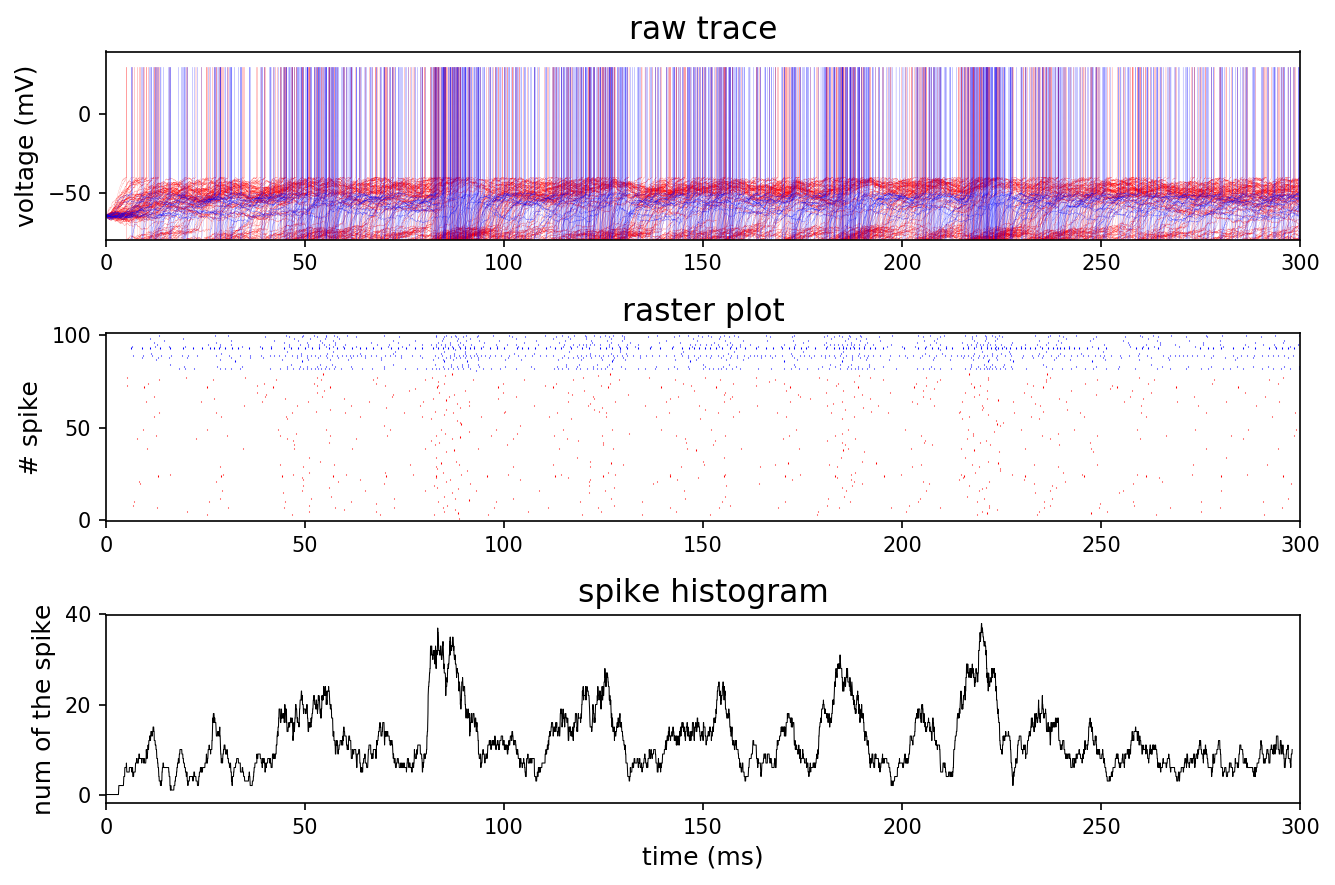

In [90]:
show_summaray(ntk_w_pfc2)

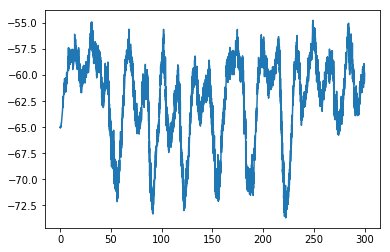

In [91]:
plt.plot(nrn._times, np.average(ntk_w_pfc.vcells, axis=1))

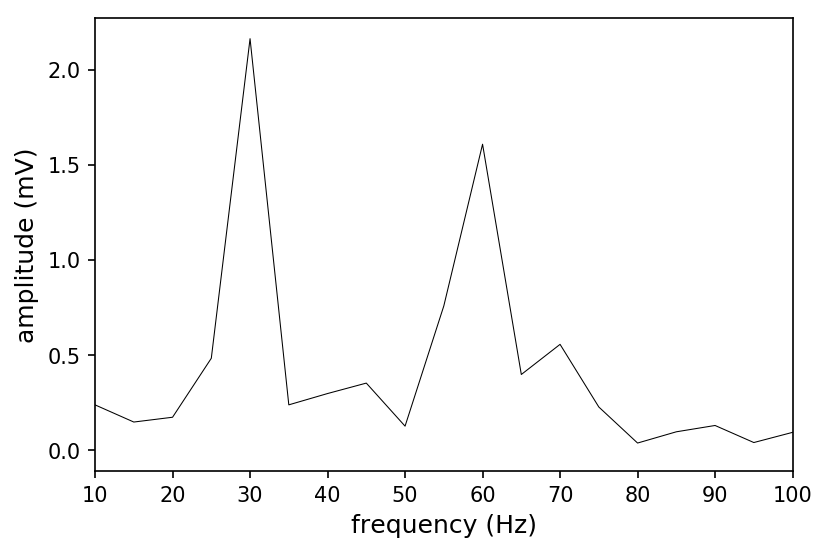

In [92]:
f, fx = get_fft_summary(np.average(ntk_w_pfc.vcells, axis=1), [50, 250])

# y = gaussian_filter1d(vsum, 10)
# f, fx = get_fft_summary(y, [50, 250])

# run with various g

In [149]:
nrn.set_times(tmax=250, dt=0.01)
seed = 102400
nrn.set_seed(seed)

In [150]:
gbar_pfc_exc = np.linspace(0, 0.001, 10)
gbar_pfc_inh = np.linspace(0, 0.001, 10)
gbar_x = 0.004

# ntk_w_pfcs
for n in range(5): # MC simulation
    for i, g_exc in enumerate(gbar_pfc_exc): # row
        for j, g_inh in enumerate(gbar_pfc_inh): # columnm

            gbar_m = [[gbar_x, g_exc, g_inh], [gbar_x/10, g_exc/10, g_inh/10]]
            gbar_s = [[gbar_x/10, g_exc/10, g_inh/10], [gbar_x/100, g_exc/100, g_inh/100]]

            target_ids_all, gbar_all, es_all = set_ext_params(n_excs, n_pfcs_exc, n_pfcs_inh, 2, 4, cell_types, gbar_m, gbar_s)

            ntk_w_pfcs = nrn.CellNetwork(**setting, g_ext=g_excs_all, e_ext=es_all, gbar_ext=gbar_all, target_id=target_ids_all, std=0.1)
            ntk_w_pfcs.run()

            np.save('./data/w_pfc/ntk_w_pfc_%d%d%d_v'%(i, j, n), ntk_w_pfcs.vcells)
            np.save('./data/w_pfc/ntk_w_pfc_%d%d%d_spk'%(i, j, n), ntk_w_pfcs.spks)


100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:43<00:00, 574.99it/s]


In [154]:
44 * 100 / 60 / 60 * 5

6.111111111111111

In [151]:
# load image
vsums = []
for i, g_exc in enumerate(gbar_pfc_exc):
    vsums.append([])
    for j, g_inh in enumerate(gbar_pfc_inh):
        val = np.load('./data/ntk_w_pfc_%d_%d_v.npy'%(i, j))
        vsums[-1].append(np.average(val, axis=1))

In [152]:
f_peaks = np.zeros([5, 5])

for i in range(5):
    for j in range(5):
        
        idt = (nrn._times>50) & (nrn._times<250)
        f, fx = getFFT(vsums[i][j], idt)
        idf = f > 1
        f = f[idf]
        fx = fx[idf]
        f_peaks[i, j] = find_peak(fx, f)


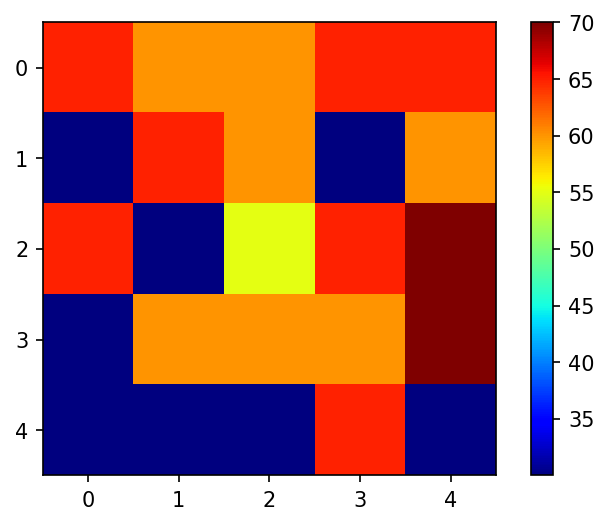

In [153]:
plt.figure(dpi=150)
plt.imshow(f_peaks, cmap='jet')
plt.colorbar()
plt.show()

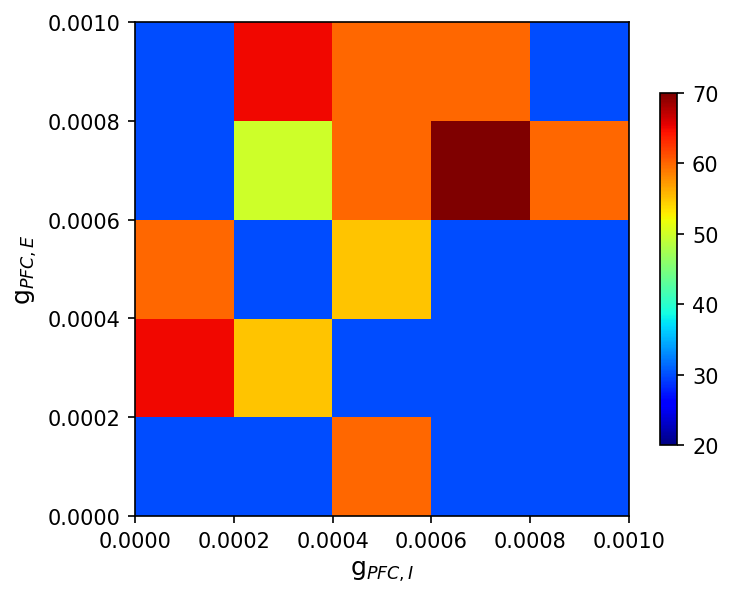

In [289]:
plt.figure(dpi=150, figsize=(5, 5))
plt.imshow(f_peaks, cmap='jet', vmin=20, vmax=70, origin='lower', extent=(gbar_pfc_inh[0], gbar_pfc_inh[-1], gbar_pfc_exc[0], gbar_pfc_exc[-1]))
plt.colorbar(shrink=0.5)
plt.tight_layout()
plt.xlabel(r'g$_{PFC, I}$', fontsize=12)
plt.ylabel(r'g$_{PFC, E}$', fontsize=12)
plt.show()